## Introduction
The goal of this analysis is to compare two experiment groups (0 and 1) to determine if there are any significant differences in the way users interact with the search function. Specifically, we will derive a set of session-related features to analyze the `selection` patterns and test for differences between the two groups using hypothesis testing.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("2024InternshipData.csv")
data.head()

,time_epoch,device_id,event_data,event_id
0,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted
1,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted
2,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted
3,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",searchRestarted
4,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,"{""session_id"": ""65ba8f8e3a23c60ec6a8d6e83e6ad2...",sessionFinished


## Assumptions
During the analysis I have made several assumptions about the dataset structure and meaning of some fields. Most of them only ease the processing a bit, and if untrue would only impact the approach slightly. Hereby I list all of them.

- `time_epoch` is time measured in $ms$ since some common timestamp (so no further processing of the field is needed when analyzing $\Delta t$ between events)
- `event_data` JSON field is always of the same format and holds `session_id`, `experimentGroup`, `eventIndex`, `queryLength` and `selectedIndexes`
- `session_id` is unique for all devices (so is enough to act as a key to session on its own, without being a pair with `device_id`)
- `selectedIndexes`, if present, is always a list of length $1$
- selection is only being performed at the end of the session (if being performed at all)
- `queryLength` stands for length of user query typed in the search field in characters
- `experimentGroup` divides the dataset in two independent samples

## Preprocessing
In this section I perform initial preprocessing of the dataframe, so I:
- flatten json field `event_data`
- unwrap `selectedIndexes` from lists (since they all are of length 1)

In [2]:
import json

df = data.copy()
df['event_json'] = df['event_data'].apply(json.loads)
df = pd.concat([df, pd.json_normalize(df['event_json'])], axis=1)
df = df.drop(['event_data', 'event_json'], axis=1)
df = df.rename(columns={'searchStateFeatures.queryLength': 'queryLength'})
df.head()

,time_epoch,device_id,event_id,session_id,experimentGroup,selectedIndexes,eventIndex,queryLength
0,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,searchRestarted,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,None,0,11
1,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,searchRestarted,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,None,1,12
2,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,searchRestarted,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,None,2,13
3,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,searchRestarted,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,None,3,14
4,1.699911e+12,9476ff0ed144326d4a58e066f6fefdcc,sessionFinished,65ba8f8e3a23c60ec6a8d6e83e6ad252,1,[0],4,13


In [3]:
df['selectedIndexes'] = df['selectedIndexes'].apply(lambda x: x[0] if x else None)

## Feature Extraction

In this section I perform feature extraction: I try to form new meaningful features of the dataset from the existing one.

### Session-related features
Since data about individual events does not hold much information on its own, I gather events into their respective sessions.

I extract:
- Session duration (in ms)
- Number of events during session
- Maximum and minimum query lengths during event
    - As well as lengths of initial query and ending query
- What index was selected as a result of the session (and if none was chosen)
- Number of letter deletions
- Whether the user selected one of the top-3 features suggested
- Average and median time between events
- Dummy for sessions ending immediately after first query
- Search restart
    - Time between sessions for the same user?
- Full query rewrites during session

In [4]:
# Session duration
durations = df.groupby(['session_id'])['time_epoch'].agg(duration=lambda x: max(x) - min(x))

# Number of events per session
n_events = df.groupby(['session_id'])['eventIndex'].agg(n_events=lambda x: max(x) + 1)

# First and last query lengths, maximum, minimum, average query length per session.
q_lengths = df.groupby(['session_id'])['queryLength'].agg(initLength=lambda x: x.iloc[0], endLength=lambda x: x.iloc[-1], minLength='min', maxLength='max', avgLength='mean')

In [5]:
selections = df.groupby(['session_id'])['selectedIndexes'].agg(selection=lambda x: x[~x.isna()])

# Field selected
selections['selection'] = selections['selection'].apply(lambda x: int(x) if x.size > 0 else None)

# Dummy feature for field not being selected
selections['no_selection'] = selections['selection'].isna()

In [6]:
shifted = df[['eventIndex', 'queryLength']].shift(1).rename({'eventIndex': 'pastIndex', 'queryLength': 'pastLength'}, axis=1)
joined = pd.concat([df[['eventIndex', 'queryLength']], shifted], axis=1)
df['delete_event'] = (joined['eventIndex'] > joined['pastIndex']) & (joined['queryLength'] < joined['pastLength'])

# Number and share of deletions (character removed during an event)
n_deletions = df.groupby(['session_id'])['delete_event'].agg(n_deletions='sum', perc_deletions=lambda x: x.sum() / x.shape[0])

In [7]:
# Dummy feature for whether one of the top options was selected as a result of a session
top_selection = (selections['selection'] <= 3) & (~selections['no_selection'])
top_selection

session_id
0000e8368bb227b7c9fce3fb0b42f6f7    False
000114b6c740c1b8561e147b65a26953     True
000995b53f82f8f0b9a1a9c85d46c013    False
000ab1e068f19dfb54dc2c356032513b    False
00116baec1d992039ad57fa48e6a1345    False
                                    ...  
ffef132ed76374aeeb27e11c693ca74f    False
ffef53d60da3506cbac08c324ff19c30    False
fff35110afaf86ea518c91642bf964cd    False
fff6e593b9e5884ca1eaac2e67451b21    False
fff920594cb6012fc7877889d3e0c460     True
Length: 15347, dtype: bool

In [8]:
# Auxiliary dataframe for features related to time-related features for events
past = df[['time_epoch', 'eventIndex']].shift(1).rename({'time_epoch': 'past_time', 'eventIndex': 'pastIndex'}, axis=1)
present = df[['time_epoch', 'eventIndex']]
together = pd.concat([past, present], axis=1)
together

,past_time,pastIndex,time_epoch,eventIndex
0,NaN,NaN,1.699911e+12,0
1,1.699911e+12,0.0,1.699911e+12,1
2,1.699911e+12,1.0,1.699911e+12,2
3,1.699911e+12,2.0,1.699911e+12,3
4,1.699911e+12,3.0,1.699911e+12,4
...,...,...,...,...
107339,1.716995e+12,12.0,1.716995e+12,13
107340,1.716995e+12,13.0,1.716995e+12,14
107341,1.716995e+12,14.0,1.716995e+12,15
107342,1.716995e+12,15.0,1.716995e+12,16


In [9]:
together['delta'] = together['time_epoch'] - together['past_time']

# Mask for identifying different sessions
mask = (together['eventIndex'] > together['pastIndex'])
together['delta'] *= mask
together['delta'] = together['delta'].fillna(0)
df['delta'] = together['delta']

# Dataframe with mean, maximum and median times per event within same session
timings = df.groupby(['session_id'])['delta'].agg(mean_time_per_event=lambda x: x.iloc[1:].mean(), max_time_per_event='max', med_time_per_event=lambda x: x.iloc[1:].median())
timings['mean_time_per_event'] = timings['mean_time_per_event'].fillna(0)
timings['med_time_per_event'] = timings['med_time_per_event'].fillna(0)
# I am using .iloc[1:], delta of 0'th event in a session is 0
    
timings

,mean_time_per_event,max_time_per_event,med_time_per_event
session_id,,,
0000e8368bb227b7c9fce3fb0b42f6f7,5095.570312,5095.570312,5095.570312
000114b6c740c1b8561e147b65a26953,9235.615479,9235.615479,9235.615479
000995b53f82f8f0b9a1a9c85d46c013,5887.382847,9428.574951,6293.497803
000ab1e068f19dfb54dc2c356032513b,3700.767529,7589.488281,3992.935791
00116baec1d992039ad57fa48e6a1345,4485.227539,4485.227539,4485.227539
...,...,...,...
ffef132ed76374aeeb27e11c693ca74f,3339.226685,4229.539307,3339.226685
ffef53d60da3506cbac08c324ff19c30,3436.803223,3436.803223,3436.803223
fff35110afaf86ea518c91642bf964cd,3847.204199,6950.437256,3399.706299


In [10]:
# Dummy features for user finding the option they were searching for immediately, and for user immediately being dissatisfied with search results
quickly_found = (n_events['n_events'] == 2) & (~selections['no_selection'])
quickly_closed = (n_events['n_events'] == 2) & (selections['no_selection'])

In [11]:
# Number of times the user had to rewrite the query entirely during a session
n_rewrites = df.groupby(['session_id'])['queryLength'].agg(n_rewrites=lambda x: (x == 0).sum())

## Compose into one dataset and EDA
Here I simply compose the auxiliary dataframes from previous cells into one and try to explore the new features

In [12]:
user_ids = df.groupby(['session_id'])['device_id'].agg(user_id=lambda x: x.iloc[0])
exp_groups = df.groupby(['session_id'])['experimentGroup'].agg(experiment_group=lambda x: x.iloc[0])

In [13]:
sessions = pd.concat([user_ids['user_id'], exp_groups['experiment_group'], durations['duration'], n_events['n_events'], ], axis=1)
sessions = sessions.merge(q_lengths, on='session_id')
sessions = sessions.merge(selections, on='session_id')

In [14]:
sessions['top_selection'] = top_selection
sessions = sessions.merge(n_deletions, on='session_id')
sessions = sessions.merge(timings, on='session_id')

In [15]:
sessions['quickly_found'] = quickly_found
sessions['quickly_closed'] = quickly_closed
sessions = sessions.merge(n_rewrites, on='session_id')

In [16]:
sessions.head()

,user_id,experiment_group,duration,n_events,initLength,endLength,minLength,maxLength,avgLength,selection,no_selection,top_selection,n_deletions,perc_deletions,mean_time_per_event,max_time_per_event,med_time_per_event,quickly_found,quickly_closed,n_rewrites
session_id,,,,,,,,,,,,,,,,,,,,
0000e8368bb227b7c9fce3fb0b42f6f7,5bb3d5c74aa4a1fbdf383d4a787a4e15,1,5095.570312,2,2,3,2,3,2.5000,10.0,False,False,0,0.00,5095.570312,5095.570312,5095.570312,True,False,0
000114b6c740c1b8561e147b65a26953,9863d04ec544f07baae7cf344110a6fb,1,9235.615479,2,5,6,5,6,5.5000,0.0,False,True,0,0.00,9235.615479,9235.615479,9235.615479,True,False,0
000995b53f82f8f0b9a1a9c85d46c013,19acba1dacc1fd0e4a472fd45390e5c8,0,41211.679932,8,0,7,0,7,3.5000,11.0,False,False,0,0.00,5887.382847,9428.574951,6293.497803,False,False,1
000ab1e068f19dfb54dc2c356032513b,c65da4e5f0b68cefa4f800a1d51cf7b9,0,55511.512939,16,10,2,0,16,10.3125,10.0,False,False,4,0.25,3700.767529,7589.488281,3992.935791,False,False,1
00116baec1d992039ad57fa48e6a1345,db9c5878e693d70de924fb6a6224fe40,1,4485.227539,2,103,104,103,104,103.5000,10.0,False,False,0,0.00,4485.227539,4485.227539,4485.227539,True,False,0


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numeric_comparisons(df, numeric_cols):
    """Plot comparisons in numeric features between experiment groups
    
    Keyword arguments:
    df -- dataframe to plot from
    numeric_cols -- list of names of numeric columns from df to plot
    """
    n_cols = 2
    n_rows = (len(numeric_cols) + 1) // 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.boxplot(x='experiment_group', y=col, data=df, ax=axes[i])
        axes[i].set_title(f'{col} by Experiment Group')

    plt.tight_layout()
    plt.show()

def plot_percentage_categorical_comparisons(df, cat_cols):
    """Plot comparisons in percentages for categorical features
    
    Keyword arguments:
    df -- dataframe to plot from
    cat_cols -- list of names of categorical columns from df to plot
    """
    n_cols = 2
    n_rows = (len(cat_cols) + 1) // 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        # Calculate percentages
        percentages = df.groupby('experiment_group')[col].value_counts(normalize=True).unstack()
        
        # Create percentage plot
        percentages.plot(kind='bar', stacked=False, ax=axes[i])
        
        axes[i].set_title(f'{col} by Experiment Group (Percentage)')
        axes[i].set_xlabel('Experiment Group')
        axes[i].set_ylabel('Percentage')
        axes[i].legend(title=col)
        
        # Add percentage labels on the bars
        for c in axes[i].containers:
            axes[i].bar_label(c, fmt='%.2f%%', label_type='center')

    plt.tight_layout()
    plt.show()

In [18]:
numeric_cols = ['duration', 'n_events', 'initLength', 'endLength', 'avgLength', 'n_deletions', 'mean_time_per_event']
cat_cols = ['no_selection', 'top_selection', 'quickly_found', 'quickly_closed']

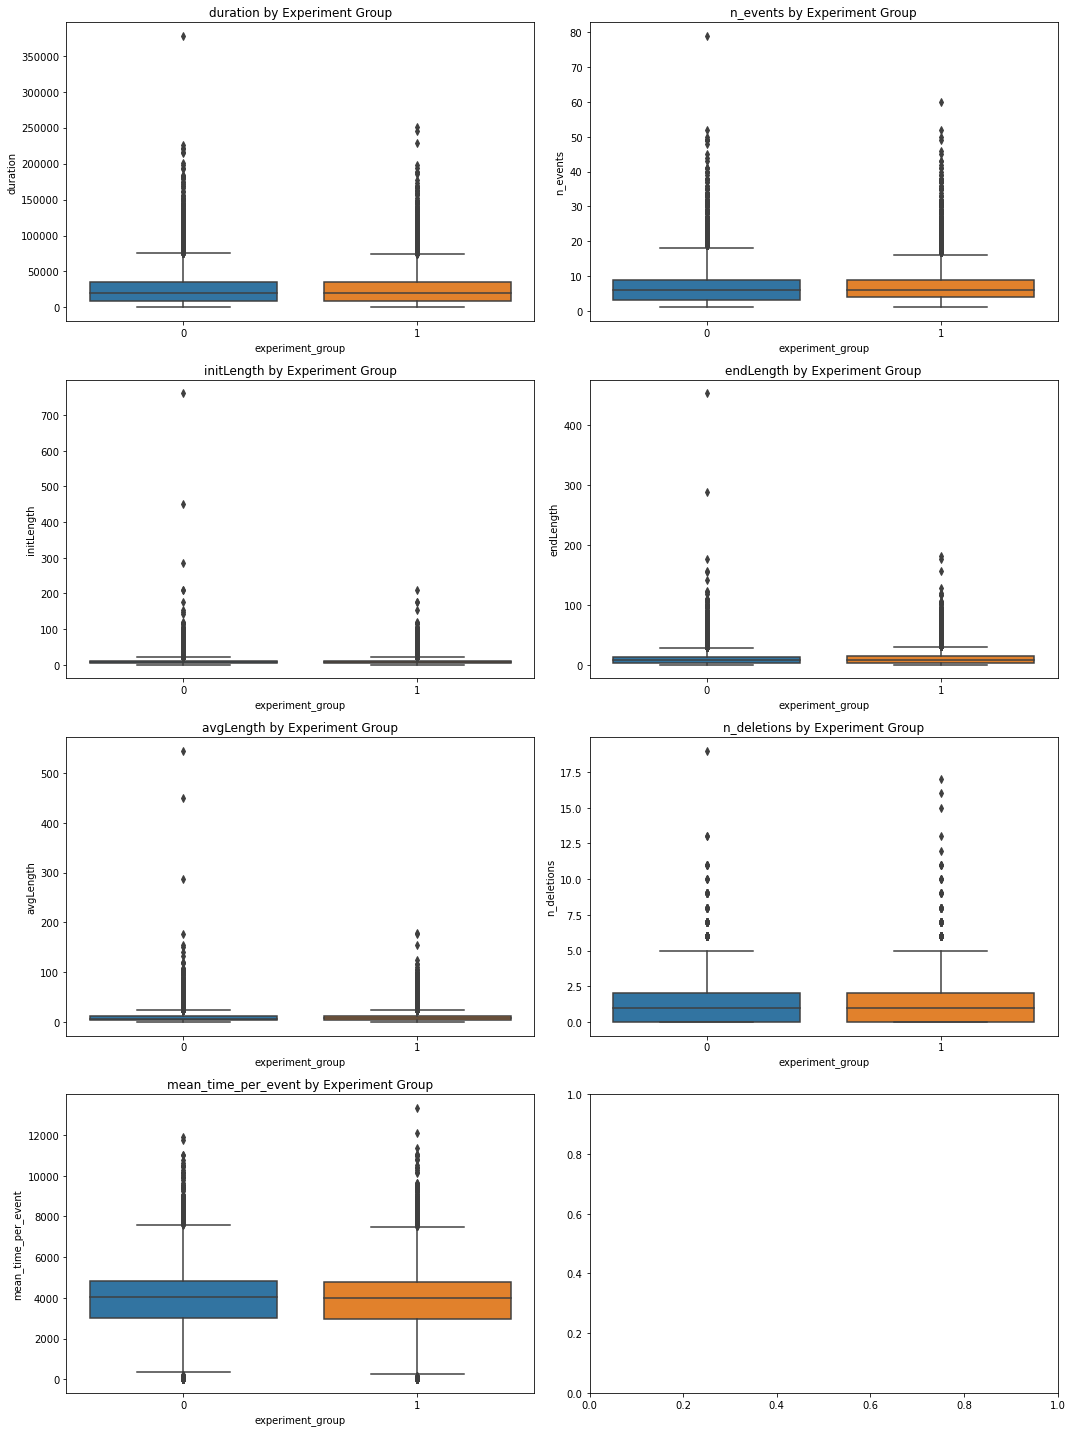

In [19]:
plot_numeric_comparisons(sessions, numeric_cols)

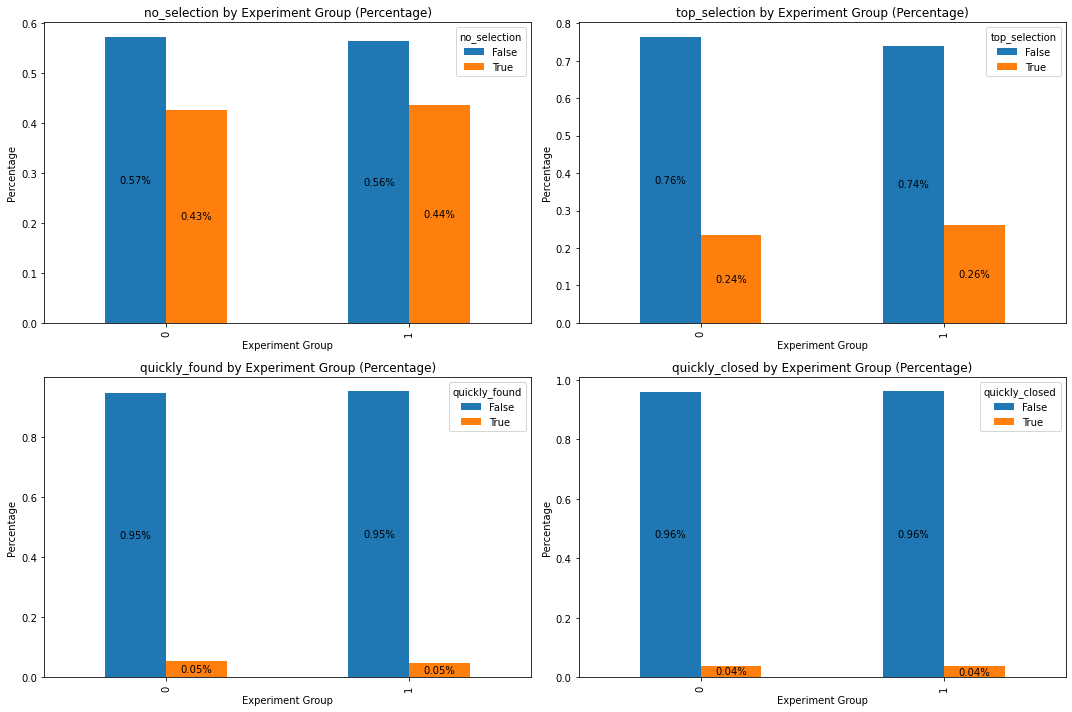

In [20]:
plot_percentage_categorical_comparisons(sessions, cat_cols)

#### Intermediary conclusion
- Judging only from the plots, there is no immediate noticeable difference between the experiment groups
- The biggest difference is present in the `top_selection` feature and also does not appear striking
- Nevertheless, before jumping to any conclusions, we have to perform hypothesis testing on these features

#### Hypothesis testing
For numerical features, we shall perform a t-test on difference in means between experiment groups:
- Null hypothesis ($H_0$): There is no significant difference in means of selected feature between the two experiment groups (assuming sample independence).
- Alternative hypothesis ($H_1$): There is significant difference in means of selected feature between the two experiment groups.

For categorical features, I perform a chi-squared test on difference in frequencies between experiment groups:
- Null hypothesis ($H_0$): There is no significant difference in frequencies of selected feature between the two experiment groups (assuming independent samples).
- Alternative hypothesis ($H_1$): There is significant difference in frequencies of selected feature between the two experiment groups.

In [21]:
from scipy import stats

def perform_statistical_tests(df, numeric_cols, cat_cols):
    """Perform hypothesis testing on dataframe columns.
    We utilize `scipy.stats` implementation of t-test for testing difference in means for numeric features
    and chi-squared test for categorical features
    
    Keyword arguments:
    df -- dataframe to perform tests on
    numeric_cols -- names of numeric columns from the dataframe to perform testing on
    cat_cols -- names of categorical columns from the dataframe to perform testing on
    """
    # numeric_cols = ['duration', 'n_events', 'initLength', 'endLength', 'avgLength', 'n_deletions', 'mean_time_per_event']
    # cat_cols = ['no_selection', 'top_selection', 'quickly_found', 'quickly_closed']

    results = {}

    for col in numeric_cols:
        group0 = df[df['experiment_group'] == 0][col]
        group1 = df[df['experiment_group'] == 1][col]
        t_stat, p_value = stats.ttest_ind(group0, group1)
        results[col] = {'test': 't-test', 't_statistic': t_stat, 'p_value': p_value}

    for col in cat_cols:
        contingency_table = pd.crosstab(df['experiment_group'], df[col])
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        results[col] = {'test': 'chi-square', 'chi2_statistic': chi2, 'p_value': p_value}

    return results

test_results = perform_statistical_tests(sessions, numeric_cols, cat_cols)
for variable, result in test_results.items():
    print(f"\n{variable}:")
    for key, value in result.items():
        print(f"  {key}: {value}")


duration:
  test: t-test
  t_statistic: -0.009316968817752022
  p_value: 0.9925663630924576

n_events:
  test: t-test
  t_statistic: -0.3656236565032616
  p_value: 0.7146509599656845

initLength:
  test: t-test
  t_statistic: 0.4346208327353621
  p_value: 0.6638437823644832

endLength:
  test: t-test
  t_statistic: 0.4844949415061851
  p_value: 0.6280415685944661

avgLength:
  test: t-test
  t_statistic: 0.39913419944408246
  p_value: 0.6897998784756478

n_deletions:
  test: t-test
  t_statistic: -0.14317540536877668
  p_value: 0.8861535332766582

mean_time_per_event:
  test: t-test
  t_statistic: 1.2362876148089335
  p_value: 0.2163705958428889

no_selection:
  test: chi-square
  chi2_statistic: 1.2375588585805535
  p_value: 0.26594204047737197

top_selection:
  test: chi-square
  chi2_statistic: 12.765377130023246
  p_value: 0.0003530943969221398

quickly_found:
  test: chi-square
  chi2_statistic: 2.2697084733573987
  p_value: 0.1319247162923532

quickly_closed:
  test: chi-square


#### Hypothesis testing conclusion
As a result of the hypothesis testing performed in the cell above, we have:
- failed to reject the null hypothesis of means of numerical features being equal between experiment groups
- rejected the null hypothesis of frequencies of `top_selection` being equal between experiment groups with level of significance $\alpha=0.001$
    - we have thus found statistically significant difference between experiment groups for `top_selection`
- failed to reject the null hypothesis for the rest of categorical features

#### Histogram of `selection` between experiment groups
- Now that we have noticed a significant difference in selection patterns between experiment groups, I shall plot the overlapping histogram of `selection` feature to highlight the differences

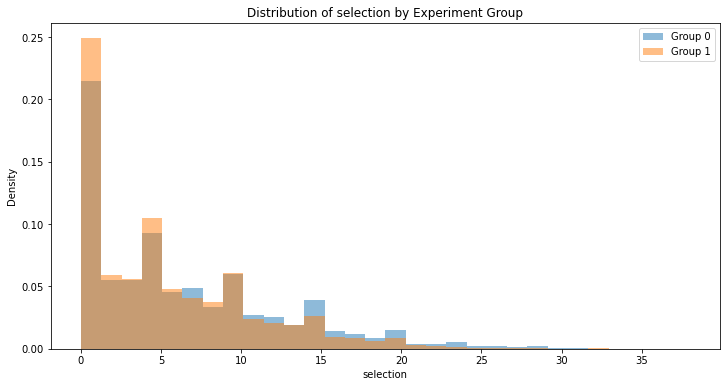

In [22]:
def plot_overlapping_histograms(df, column='selection', bins=30):
    """Plot an overlapping histogram based on a column from a dataframe
    
    Keyword arguments:
    df -- dataframe to plot from
    column -- column in dataframe to plot from
    bins -- number of bins in the resulting histogram
    """
    
    group0 = df[df['experiment_group'] == 0][column]
    group1 = df[df['experiment_group'] == 1][column]
    
    min_val = min(group0.min(), group1.min())
    max_val = max(group0.max(), group1.max())
    
    plt.figure(figsize=(12, 6))
    
    plt.hist(group0, bins=bins, alpha=0.5, label='Group 0', range=(min_val, max_val), density=True)
    plt.hist(group1, bins=bins, alpha=0.5, label='Group 1', range=(min_val, max_val), density=True)
    
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.title(f'Distribution of {column} by Experiment Group')
    
    plt.legend()
    
    plt.show()
    
plot_overlapping_histograms(sessions, column='selection', bins=30)

## Conclusion
- As we can observe from the graph and from the series of hypothesis tests, we have found significant differences in selection patterns of people from different experiment groups.
- Users from experiment group 1 select the top option from the search box consistently more often than users from group 0.

> #### Post-work thoughts
> Regardless of the outcome of this submission, I thank you for the opportunity to work on this assignment. It has been a pleasure to investigate the dataset without knowing where I would spot the difference, despite the dataset being synthetic.